## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [33]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt
import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from hparams import create_hparams
from model import Tacotron2
from train import load_model
from text import text_to_sequence

import torch.nn.functional as F

# from layers import TacotronSTFT
# from audio_processing import griffin_lim
# from stft import STFT

In [2]:
%matplotlib inline

In [3]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [4]:
hparams = create_hparams()
hparams.sampling_rate = 22050
hparams.gpu = False

device = torch.device('cuda') if hparams.gpu else torch.device('cpu')

#### Load model from checkpoint

In [5]:
checkpoint_path = "tacotron2_statedict.pt"
model = load_model(hparams)
load_kwargs = {} if hparams.gpu else {'map_location':'cpu'} 
model.load_state_dict(torch.load(checkpoint_path, **load_kwargs)['state_dict'])
_ = model.eval()

#### Load WaveGlow for mel2audio synthesis

In [6]:
waveglow_path = 'waveglow_old.pt'
waveglow = torch.load(waveglow_path, **load_kwargs)['model']
waveglow.to(device)

/Users/victor/anaconda3/envs/waveglow/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'glow_old.WaveGlow' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/victor/anaconda3/envs/waveglow/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/victor/anaconda3/envs/waveglow/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve 

WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0): WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (cond_layers): ModuleList(
        (0): Conv1d(640, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(640, 1

#### Prepare text input

In [14]:
# text = "Waveglow is really awesome!"
# text = "Ppupapupplbbf. bb."
# text = "p. puh. p. hngeeeehh."
# text = "text to speak ghgt tch tchith long one this time hbuf tchlin verrry loooong cluclull"
text = """’Twas brillig, and the slithy toves
      Did gyre and gimble in the wabe:
All mimsy were the borogoves,
      And the mome raths outgrabe.
"""
# text = """
# “Beware the Jabberwock, my son!
#       The jaws that bite, the claws that catch!
# Beware the Jubjub bird, and shun
#       The frumious Bandersnatch!” """
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.from_numpy(sequence).to(device).long()

In [15]:
sequence

tensor([[ 3, 57, 60, 38, 56, 11, 39, 55, 46, 49, 49, 46, 44,  6, 11, 38, 51, 41,
         11, 57, 45, 42, 11, 56, 49, 46, 57, 45, 62, 11, 57, 52, 59, 42, 56, 11,
         41, 46, 41, 11, 44, 62, 55, 42, 11, 38, 51, 41, 11, 44, 46, 50, 39, 49,
         42, 11, 46, 51, 11, 57, 45, 42, 11, 60, 38, 39, 42,  8, 11, 38, 49, 49,
         11, 50, 46, 50, 56, 62, 11, 60, 42, 55, 42, 11, 57, 45, 42, 11, 39, 52,
         55, 52, 44, 52, 59, 42, 56,  6, 11, 38, 51, 41, 11, 57, 45, 42, 11, 50,
         52, 50, 42, 11, 55, 38, 57, 45, 56, 11, 52, 58, 57, 44, 55, 38, 39, 42,
          7, 11]])

#### Decode text input and plot results

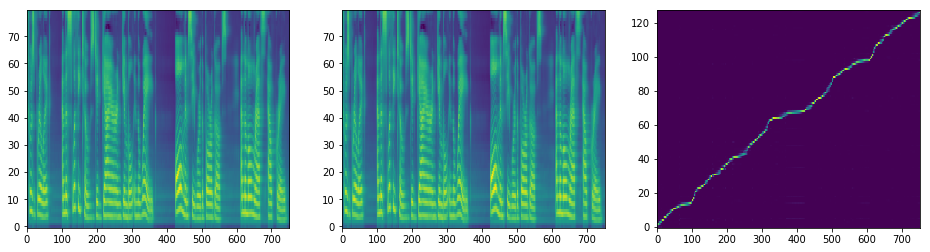

In [16]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [13]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.6666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [17]:
# stereo with different z
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet.expand(2, -1, -1), sigma=0.5)
ipd.Audio(audio.data.cpu().numpy(), rate=hparams.sampling_rate)

In [ ]:
audio.shape

In [20]:
mel_outputs_postnet.shape

torch.Size([1, 80, 446])

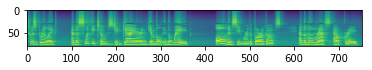

In [20]:
#compress spectrum
spec_size = mel_outputs_postnet.size(1)
new_size = int(spec_size/1.5)
size_diff = spec_size-new_size
resamp = F.interpolate(mel_outputs_postnet.transpose(1,2), new_size).transpose(1, 2)
resamp = torch.cat((
    resamp, 
    resamp[:, -1, :].expand(1, size_diff, -1) - 5*torch.linspace(0, 1, size_diff).view(1, size_diff, 1).expand(1, -1, resamp.size(2))
    ), dim=1)
plt.imshow(resamp.data.cpu().numpy()[0, ::-1])

In [21]:
with torch.no_grad():
    audio = waveglow.infer(resamp, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

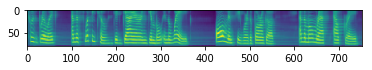

In [22]:
# expand spectrum
spec_size = mel_outputs_postnet.size(1)
new_size = int(spec_size*1.5)
resamp = F.interpolate(mel_outputs_postnet.transpose(1,2), new_size).transpose(1, 2)
resamp = resamp[:, :spec_size, :]
plt.imshow(resamp.data.cpu().numpy()[0, ::-1])

In [23]:
with torch.no_grad():
    audio = waveglow.infer(resamp, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

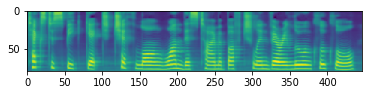

In [67]:
#shift spectrum down
spec_size = mel_outputs_postnet.size(1)
bins = 2
resamp = mel_outputs_postnet[:, bins:, :]
resamp = torch.cat((
    resamp, 
    resamp[:, -1, :].expand(1, bins, -1) 
    ), dim=1)
plt.imshow(resamp.data.cpu().numpy()[0, ::-1])

In [68]:
with torch.no_grad():
    audio = waveglow.infer(resamp, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [135]:
def sharp_curve(x, lo, hi, bend):
    m = np.clip((x-lo)/(hi-lo), 0, 1)**bend
    return x*m + lo*(1-m)

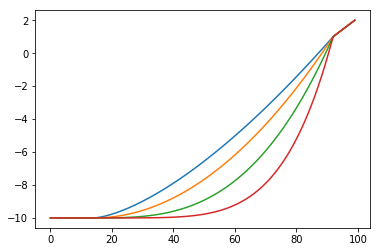

In [144]:
plt.plot(np.array((
    sharp_curve(np.linspace(-12, 2, 100), -10, 1, 1/2),
    sharp_curve(np.linspace(-12, 2, 100), -10, 1, 1),
    sharp_curve(np.linspace(-12, 2, 100), -10, 1, 2),
    sharp_curve(np.linspace(-12, 2, 100), -10, 1, 4)
)).T)

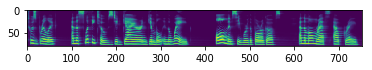

In [154]:
# sharpen spectrum
# sharp = mel_outputs_postnet*2
sharp = mel_outputs_postnet.data.cpu().numpy()
sharp = sharp_curve(sharp, -10, -3, 4)
plt.imshow(sharp[0, ::-1])
sharp = torch.tensor(sharp)

In [155]:
with torch.no_grad():
    audio = waveglow.infer(sharp, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

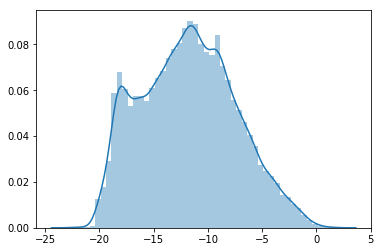

In [38]:
sns.distplot(mel_outputs_postnet.view(-1).data)

In [46]:
waveglow.upsample.weight.numel()

6553600

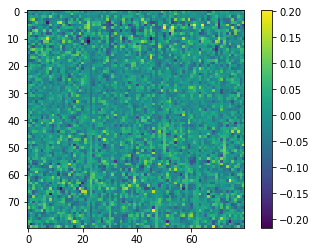

In [109]:
# fc channel matrix
g = plt.imshow(waveglow.upsample.weight[:,:,128].data)
plt.colorbar(g)

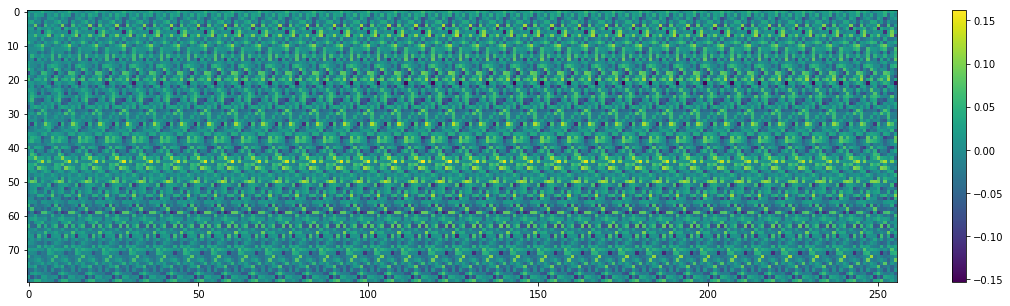

In [119]:
# filter for a single input channel
fig, ax = plt.subplots(1,1, figsize=(20, 5))
g = ax.imshow(waveglow.upsample.weight[50,:,:256].data)
plt.colorbar(g)

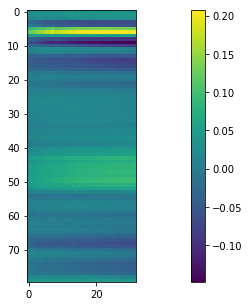

In [183]:
# filter for a single output channel
fig, ax = plt.subplots(1,1, figsize=(20, 5))
g = ax.imshow(waveglow.upsample.weight[:,50,0:256:8].data)
plt.colorbar(g)

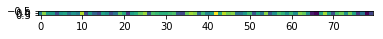

In [116]:
plt.imshow(waveglow.upsample.bias.data.view(1, -1))

In [61]:
upsampled = waveglow.upsample(mel_outputs_postnet).data.cpu().numpy()
upsampled.shape

(1, 80, 193280)

In [62]:
mel_outputs_postnet.shape

torch.Size([1, 80, 752])

In [65]:
upsampled.shape[-1]/mel_outputs_postnet.shape[-1]

257.02127659574467

In [101]:
audio.shape

torch.Size([1, 192512])

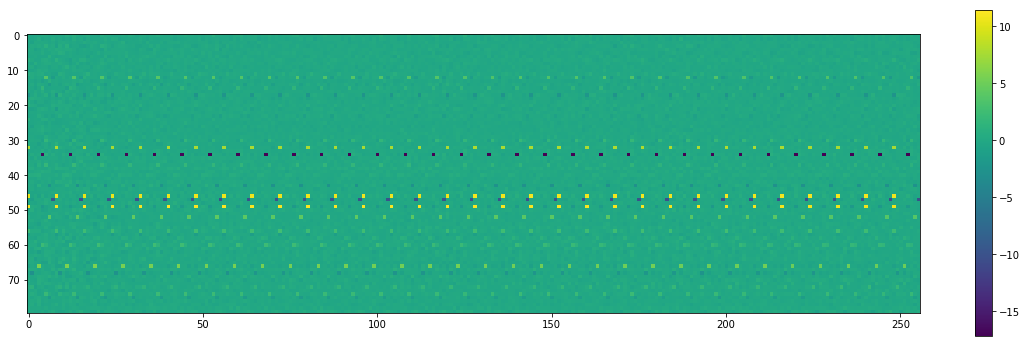

In [94]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))
g = ax.imshow(upsampled[0, ::-1, 1024:(1024+256)])
plt.colorbar(g)

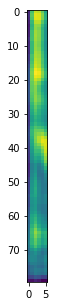

In [77]:
fig, ax = plt.subplots(1,1, figsize=(16, 5))
ax.imshow(mel_outputs_postnet.data.cpu().numpy()[0, ::-1, :6])

In [168]:
6553600/sum(w.numel() for w in waveglow.parameters())

0.024426865437103578

In [170]:
# for n, w in waveglow.named_parameters():
#     display(n, w.numel())
waveglow.WN[7]
# sum(w.numel() for n,w in waveglow.named_parameters() if 'cond_layers' in n)

WN(
  (in_layers): ModuleList(
    (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
  )
  (cond_layers): ModuleList(
    (0): Conv1d(640, 1024, kernel_size=(1,), stride=(1,))
    (1): Conv1d(640, 1024, kernel_size=(1,), stride=(1,))
    (2): Conv1d(640, 1024, kernel_size=(1,), stride=(1,))
    (3): Conv1d(640, 1024, kernel_size=(1,), stride=(1,))
    (4): Conv

In [197]:
torch.cuda.device_count()
torch.cuda.manual_seed(0)


In [199]:
%load_ext autoreload
%autoreload 1
%aimport audiodataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
audiodataset.load_audio_to_torch(
    '../data/mozilla_common_voice/eo/clips/0a02fbc72649ab87dcab86a7d87f6d5c5b6d878ce66c75725d3a04849e34c34e360fb7518dd9e8ddcfe49284be4e253f5174df9676d2da9fde59f0e6a07f1b47.mp3', 
    22050
).max()

tensor(23243.7500)

In [211]:
audiodataset.load_audio_to_torch(
    '../Documents/REAPER Media/impulse3.wav',
    96000
).max()

/Users/victor/anaconda3/envs/waveglow/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/Users/victor/anaconda3/envs/waveglow/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


tensor(10123.)